Instalação do Kaagle e importação da chave API para importação do Data Set.

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gedeirjunior","key":"828105cafe4bba26c2796340fa2dde2f"}'}

In [3]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 98% 340M/346M [00:00<00:00, 561MB/s]
100% 346M/346M [00:00<00:00, 598MB/s]


In [5]:
!unzip -q intel-image-classification.zip

Obtenção das classes e Normalização dos dados

In [6]:
import tensorflow as tf


image_size = (150, 150)
batch_size = 32


caminho_treino = '/content/seg_train/seg_train'
caminho_teste = '/content/seg_test/seg_test'


train_ds = tf.keras.utils.image_dataset_from_directory(
    caminho_treino,
    labels='inferred',
    image_size=image_size,
    batch_size=batch_size,
)


test_ds = tf.keras.utils.image_dataset_from_directory(
    caminho_teste,
    labels='inferred',
    image_size=image_size,
    batch_size=batch_size,
)


class_names = train_ds.class_names
print("Classes encontradas:", class_names)
num_classes = len(class_names)


def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

train_ds = train_ds.map(normalize_img).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.map(normalize_img).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Classes encontradas: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Modelo inicial

In [16]:
from tensorflow.keras import models, layers

modelo_paisagem = models.Sequential()

modelo_paisagem.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
modelo_paisagem.add(layers.MaxPooling2D((2, 2)))
modelo_paisagem.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelo_paisagem.add(layers.MaxPooling2D((2, 2)))
modelo_paisagem.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelo_paisagem.add(layers.MaxPooling2D((2, 2)))


modelo_paisagem.add(layers.Flatten())
modelo_paisagem.add(layers.Dense(64, activation='relu'))
modelo_paisagem.add(layers.Dense(num_classes, activation='softmax'))

modelo_paisagem.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])


history = modelo_paisagem.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10
)

erro_teste, acc_teste = modelo_paisagem.evaluate(test_ds, verbose=2)

print('\nAcurácia com dados de Teste:', acc_teste)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


439/439 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5072 - loss: 1.2163 - val_accuracy: 0.7170 - val_loss: 0.7783
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.7541 - loss: 0.6756 - val_accuracy: 0.7750 - val_loss: 0.6290
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8083 - loss: 0.5415 - val_accuracy: 0.7790 - val_loss: 0.6414
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8512 - loss: 0.4175 - val_accuracy: 0.7873 - val_loss: 0.6488
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8801 - loss: 0.3379 - val_accuracy: 0.7767 - val_loss: 0.7244
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9103 - loss: 0.2506 - val_accuracy: 0.7803 - val_loss: 0.7255
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9321 - loss: 0.1968 - val_accuracy: 0.7803 - val_loss: 0.8202
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9440 - loss: 0.1545 - val_accuracy: 0.7

Modelo com camadas adicionais

In [24]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Dropout


modelo_paisagem = models.Sequential()

modelo_paisagem.add(RandomFlip("horizontal", input_shape=(150, 150, 3)))
modelo_paisagem.add(RandomRotation(0.1))
modelo_paisagem.add(RandomZoom(0.1))


modelo_paisagem.add(layers.Conv2D(32, (3, 3), activation='relu'))
modelo_paisagem.add(layers.MaxPooling2D((2, 2)))
modelo_paisagem.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelo_paisagem.add(layers.MaxPooling2D((2, 2)))
modelo_paisagem.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelo_paisagem.add(layers.MaxPooling2D((2, 2)))


modelo_paisagem.add(layers.Flatten())
modelo_paisagem.add(layers.Dense(64, activation='relu'))


modelo_paisagem.add(Dropout(0.5))

modelo_paisagem.add(layers.Dense(num_classes, activation='softmax'))


modelo_paisagem.summary()


modelo_paisagem.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])


history = modelo_paisagem.fit(
    train_ds,
    validation_data=test_ds,
    epochs=8
)

# Avalia o modelo no dataset de teste
erro_teste, acc_teste = modelo_paisagem.evaluate(test_ds, verbose=2)

print('\nAcurácia com dados de Teste:', acc_teste)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_3 (RandomFlip)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_3               │ (None, 150, 150, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_3 (RandomZoom)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │     1,183,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,240,518 (4.73 MB)

 Trainable params: 1,240,518 (4.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
439/439 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.4198 - loss: 1.4076 - val_accuracy: 0.6557 - val_loss: 0.9205
Epoch 2/8
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6079 - loss: 1.0451 - val_accuracy: 0.7147 - val_loss: 0.7807
Epoch 3/8
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6568 - loss: 0.9353 - val_accuracy: 0.7587 - val_loss: 0.6765
Epoch 4/8
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.6842 - loss: 0.8646 - val_accuracy: 0.7787 - val_loss: 0.6393
Epoch 5/8
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7017 - loss: 0.8155 - val_accuracy: 0.7617 - val_loss: 0.6815
Epoch 6/8
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7230 - loss: 0.7723 - val_accuracy: 0.7723 - val_loss: 0.6265
Epoch 7/8
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7359 - loss: 0.7447 - val_accuracy: 0.8027 - val_loss: 0.5762
Epoch 8/8
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7483 - loss: 0.7166 - val_accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

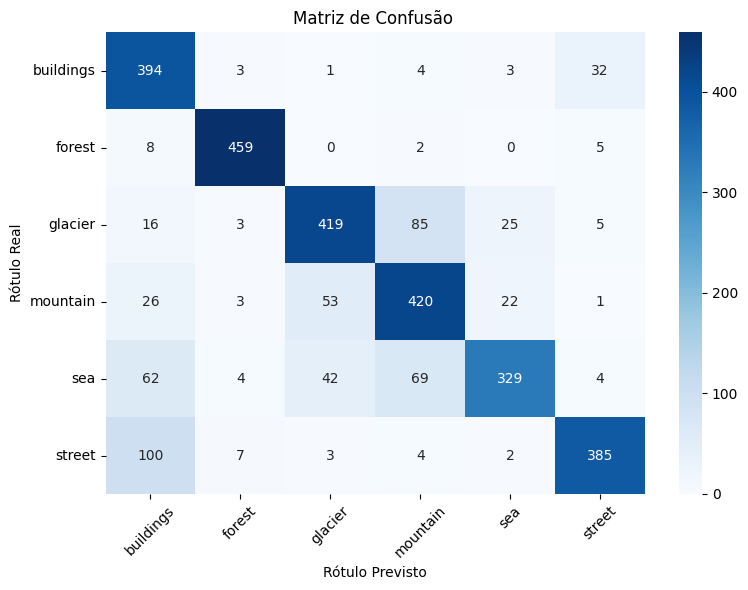

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []


for imagens, labels in test_ds:

    y_true.extend(labels.numpy())


    previsoes_batch = modelo_paisagem.predict(imagens)

    y_pred_classes = np.argmax(previsoes_batch, axis=1)
    y_pred.extend(y_pred_classes)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Matriz de Confusão ')
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

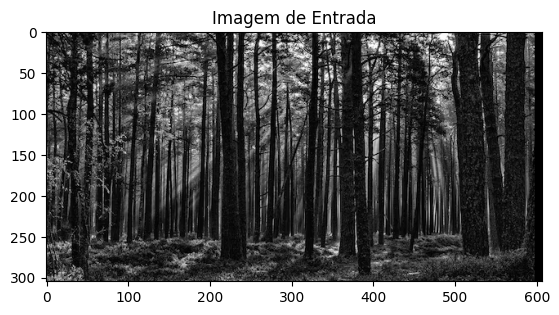

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Grau de confiança por classe:
  - 'buildings': 0.42%
  - 'forest': 98.96%
  - 'glacier': 0.01%
  - 'mountain': 0.00%
  - 'sea': 0.00%
  - 'street': 0.61%

O modelo previu a imagem como 'forest' com 98.96% de confiança.


In [25]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


caminho_da_imagem = '/content/drive/MyDrive/DataSets/Imagem-Teste.png'

try:
    nova_imagem = Image.open(caminho_da_imagem).convert('RGB')

    plt.imshow(nova_imagem)
    plt.title('Imagem de Entrada')
    plt.show()

    nova_imagem_redimensionada = nova_imagem.resize((150, 150))

    nova_imagem_array = np.array(nova_imagem_redimensionada) / 255.0

    nova_imagem_array = np.expand_dims(nova_imagem_array, axis=0)


    previsoes = modelo_paisagem.predict(nova_imagem_array)

    print("Grau de confiança por classe:")
    for i, prob in enumerate(previsoes[0]):
        print(f"  - '{class_names[i]}': {prob * 100:.2f}%")

    classe_prevista_idx = np.argmax(previsoes, axis=1)[0]
    classe_prevista = class_names[classe_prevista_idx]
    confianca_maxima = previsoes[0][classe_prevista_idx] * 100

    print(f"\nO modelo previu a imagem como '{classe_prevista}' com {confianca_maxima:.2f}% de confiança.")

except FileNotFoundError:
    print(f"Erro: O arquivo '{caminho_da_imagem}' não foi encontrado.")
    print("Verifique o caminho do arquivo e se o Google Drive está montado.")